In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### dataset information

In [4]:
from datetime import datetime

dataset = "cifar10"
dims = (32, 32, 3)
umap_prop = 1.0
num_classes = 10
PROJECTION_DIMS = 1024
labels_per_class = 'full' # full
batch_size = 512
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
datestring = (
    str(dataset)
    + "_"
    + str(umap_prop)
    + "_"
    + str(PROJECTION_DIMS)
    + "_"
    + str(labels_per_class)
    + "____"
    + datestring 
    + '_baseline'
)
print(datestring)

cifar10_1.0_1024_full____2020_08_09_12_52_41_572586_baseline


### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_CIFAR10, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_CIFAR10(flatten=False)
X_train.shape

(40000, 32, 32, 3)

In [7]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Build network

In [8]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers

In [9]:
weight_decay = 1e-4
# https://github.com/RaptorMai/Cifar10-CNN-Keras/blob/master/Cifar_better.ipynb
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=dims))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())

#model.add(Dense(512))
#model.add(Dropout(0.9))
#model.add(Dense(512))
#model.add(Dropout(0.9))


model.add(Dense(num_classes, activation='softmax'))

#model.summary()

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=20, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [12]:
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)

In [13]:
model.compile(tf.keras.optimizers.Adam(1e-4), loss = loss, metrics=['accuracy'])

In [14]:
Y_valid_one_hot = tf.keras.backend.one_hot(
    Y_valid, num_classes
)

In [15]:
Y_labeled_one_hot = tf.keras.backend.one_hot(
    Y_labeled, num_classes
)

In [16]:
history = model.fit(
    X_labeled,
    Y_labeled_one_hot,
    batch_size=batch_size,
    epochs=250,
    validation_data=(X_valid, Y_valid_one_hot),
    callbacks = [early_stopping]
)

Epoch 1/250
79/79 [==============================] - 4s 45ms/step - loss: 3.5873 - accuracy: 0.2022 - val_loss: 2.5118 - val_accuracy: 0.0970
Epoch 2/250
79/79 [==============================] - 3s 40ms/step - loss: 2.9625 - accuracy: 0.2770 - val_loss: 2.7174 - val_accuracy: 0.0998
Epoch 3/250
79/79 [==============================] - 3s 38ms/step - loss: 2.6887 - accuracy: 0.3030 - val_loss: 2.9847 - val_accuracy: 0.1007
Epoch 4/250
79/79 [==============================] - 3s 38ms/step - loss: 2.5123 - accuracy: 0.3304 - val_loss: 3.1192 - val_accuracy: 0.1001
Epoch 5/250
79/79 [==============================] - 3s 40ms/step - loss: 2.4082 - accuracy: 0.3436 - val_loss: 2.6605 - val_accuracy: 0.1247
Epoch 6/250
79/79 [==============================] - 3s 38ms/step - loss: 2.3213 - accuracy: 0.3634 - val_loss: 2.4537 - val_accuracy: 0.1730
Epoch 7/250
79/79 [==============================] - 3s 39ms/step - loss: 2.2473 - accuracy: 0.3821 - val_loss: 2.1577 - val_accuracy: 0.2914
Epoch 

79/79 [==============================] - 2s 23ms/step - loss: 1.4592 - accuracy: 0.7463 - val_loss: 1.4534 - val_accuracy: 0.7255
Epoch 59/250
79/79 [==============================] - 2s 23ms/step - loss: 1.4498 - accuracy: 0.7490 - val_loss: 1.4214 - val_accuracy: 0.7436
Epoch 60/250
79/79 [==============================] - 2s 23ms/step - loss: 1.4386 - accuracy: 0.7534 - val_loss: 1.4244 - val_accuracy: 0.7484
Epoch 61/250
79/79 [==============================] - 2s 23ms/step - loss: 1.4430 - accuracy: 0.7552 - val_loss: 1.4348 - val_accuracy: 0.7445
Epoch 62/250
79/79 [==============================] - 2s 23ms/step - loss: 1.4345 - accuracy: 0.7557 - val_loss: 1.4175 - val_accuracy: 0.7468
Epoch 63/250
79/79 [==============================] - 2s 23ms/step - loss: 1.4342 - accuracy: 0.7609 - val_loss: 1.4206 - val_accuracy: 0.7484
Epoch 64/250
79/79 [==============================] - 2s 23ms/step - loss: 1.4275 - accuracy: 0.7597 - val_loss: 1.3953 - val_accuracy: 0.7591
Epoch 65/250

79/79 [==============================] - 3s 38ms/step - loss: 1.2721 - accuracy: 0.8481 - val_loss: 1.3197 - val_accuracy: 0.8053
Epoch 116/250
79/79 [==============================] - 3s 37ms/step - loss: 1.2722 - accuracy: 0.8495 - val_loss: 1.3090 - val_accuracy: 0.8097
Epoch 117/250
79/79 [==============================] - 3s 37ms/step - loss: 1.2696 - accuracy: 0.8493 - val_loss: 1.3108 - val_accuracy: 0.8080
Epoch 118/250
79/79 [==============================] - 3s 37ms/step - loss: 1.2716 - accuracy: 0.8482 - val_loss: 1.3088 - val_accuracy: 0.8135
Epoch 119/250
79/79 [==============================] - 3s 34ms/step - loss: 1.2661 - accuracy: 0.8537 - val_loss: 1.3141 - val_accuracy: 0.8100
Epoch 120/250
79/79 [==============================] - 2s 24ms/step - loss: 1.2641 - accuracy: 0.8543 - val_loss: 1.3164 - val_accuracy: 0.8098
Epoch 121/250
79/79 [==============================] - 2s 23ms/step - loss: 1.2628 - accuracy: 0.8543 - val_loss: 1.3011 - val_accuracy: 0.8144
Epoch 

Epoch 172/250
79/79 [==============================] - 3s 38ms/step - loss: 1.1725 - accuracy: 0.9041 - val_loss: 1.2681 - val_accuracy: 0.8291
Epoch 173/250
79/79 [==============================] - 3s 37ms/step - loss: 1.1726 - accuracy: 0.9034 - val_loss: 1.2681 - val_accuracy: 0.8275
Epoch 174/250
79/79 [==============================] - 3s 38ms/step - loss: 1.1679 - accuracy: 0.9064 - val_loss: 1.2638 - val_accuracy: 0.8332
Epoch 175/250
79/79 [==============================] - 3s 37ms/step - loss: 1.1671 - accuracy: 0.9066 - val_loss: 1.2688 - val_accuracy: 0.8314
Epoch 176/250
79/79 [==============================] - 3s 37ms/step - loss: 1.1658 - accuracy: 0.9079 - val_loss: 1.2667 - val_accuracy: 0.8306
Epoch 177/250
79/79 [==============================] - 3s 37ms/step - loss: 1.1659 - accuracy: 0.9076 - val_loss: 1.2664 - val_accuracy: 0.8301
Epoch 178/250
79/79 [==============================] - 3s 37ms/step - loss: 1.1650 - accuracy: 0.9065 - val_loss: 1.2634 - val_accuracy:

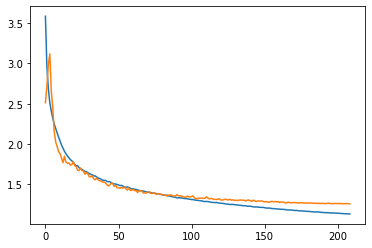

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

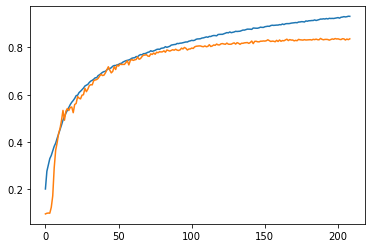

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [21]:
### data augmentation

In [22]:
tf.image

<module 'tensorflow._api.v2.image' from '/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/_api/v2/image/__init__.py'>

- https://medium.com/fenwicks/tutorial-2-94-accuracy-on-cifar10-in-2-minutes-7b5aaecd9cdd
- https://colab.research.google.com/github/davidcpage/cifar10-fast/blob/master/bag_of_tricks.ipynb#scrollTo=n___bs94Rvm2
- https://www.tensorflow.org/tutorials/images/data_augmentation#using_tfimage
- https://github.com/tensorflow/models/pull/5906/files